In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

sys.path.insert(0, '../')
#sys.path.insert(1, '/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages')
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import ROMANAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.overlap import get_overlap, get_mismatch

In [2]:
traj = RunSchwarzEccFluxInspiral()

In [3]:
fast, slow = np.load('../wave_out_p_10.0_e0.7.npy')

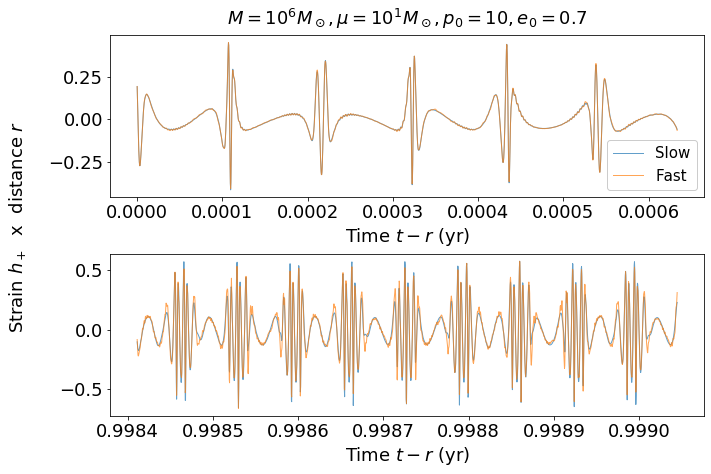

In [4]:
fig, axes = plt.subplots(2,1)
plt.subplots_adjust(hspace=0.35, left=0.15)
fig.set_size_inches(11,7)

num_pts = int(2e3)

dt = 10.0
t = np.arange(len(fast))*dt

starts = np.array([0, fast.shape[0] - num_pts])
end = starts + num_pts

for i, (st, ed, ax) in enumerate(zip(starts, end, axes)):
    inds = slice(st, ed)
    ax.plot(t[inds]/(365.25*24*3600.0), slow.real[inds], label='Slow', lw=1, alpha=0.7)
    ax.plot(t[inds]/(365.25*24*3600.0), fast.real[inds], label='Fast', lw=1, alpha=0.7)
    ax.set_xlabel(r'Time $t-r$ (yr)', fontsize=18)
    ax.tick_params(labelsize=18)
    if i == 1:
        labelpad = 15
    else:
        labelpad = 0
    #ax.set_ylabel(r'Strain $h_+r$ x distance $r$', fontsize=18, labelpad=labelpad)

fig.text(0.02, 0.5, r'Strain $h_+$  x  distance $r$', rotation='vertical', fontsize=18, va='center')    
axes[0].set_title(r'$M=10^6M_\odot, \mu=10^1M_\odot, p_0=10, e_0=0.7$', pad=10, fontsize=18)
#ax.set_xlabel('time (yr)', fontsize=18)
axes[0].legend(prop={'size': 15}, ncol=1, loc='lower right', fancybox=True, framealpha=1.0)
fig.savefig('figures/waveform_example.pdf', dpi=200)

In [4]:
M = 1e6

p0_arr, e0_arr = np.array([[10., 0.7], [11.48, 0.7], [12.96, 0.7], [14.44, 0.7], [15.92,
  0.7], [17.4, 0.7], [16.2, 0.1], [16.4, 0.2], [16.6, 0.3], [16.8,
  0.4], [17., 0.5], [17.2, 0.6]]).T

p0_arr = p0_arr
e0_arr = e0_arr
mu_arr = np.logspace(0, 3, 1000)

print(p0_arr, e0_arr)

t_end = np.zeros(len(p0_arr))
t_temp = np.zeros(len(mu_arr))
mu_best = np.zeros(len(p0_arr))
for i, (p0, e0) in enumerate(zip(p0_arr, e0_arr)):
    for j, mu in enumerate(mu_arr):
        t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)
        t_temp[j] = t[-1]
        if j % 100 == 0:
            print(j)
        
    ind = np.where(t_temp < 3.15576E+07)[0][0]
    t_end[i] = t_temp[ind]
    mu_best[i] = mu_arr[ind]
    print(p0, e0)

            

[10.   11.48 12.96 14.44 15.92 17.4  16.2  16.4  16.6  16.8  17.   17.2 ] [0.7 0.7 0.7 0.7 0.7 0.7 0.1 0.2 0.3 0.4 0.5 0.6]
0
100
200
300
400
500
600
700
800
900
10.0 0.7
0
100
200
300
400
500
600
700
800
900
11.48 0.7
0
100
200
300
400
500
600
700
800
900
12.96 0.7
0
100
200
300
400
500
600
700
800
900
14.44 0.7
0
100
200
300
400
500
600
700
800
900
15.92 0.7
0
100
200
300
400
500
600
700
800
900
17.4 0.7
0
100
200
300
400
500
600
700
800
900
16.2 0.1
0
100
200
300
400
500
600
700
800
900
16.4 0.2
0
100
200
300
400
500
600
700
800
900
16.6 0.3
0
100
200
300
400
500
600
700
800
900
16.8 0.4
0
100
200
300
400
500
600
700
800
900
17.0 0.5
0
100
200
300
400
500
600
700
800
900
17.2 0.6


10.0 0.7
11.48 0.7
12.96 0.7
14.44 0.7
15.92 0.7
17.4 0.7
16.2 0.1
16.4 0.2
16.6 0.3
16.8 0.4
17.0 0.5
17.2 0.6
17.4 0.7


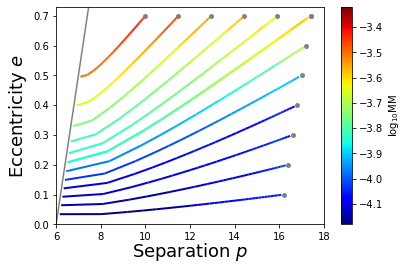

In [6]:
from scipy.interpolate import CubicSpline
from few.utils.overlap import get_mismatch
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plot_info = np.load('../plot_test_2.npy', allow_pickle=True)

p0_arr, e0_arr, mu_arr, mismatch, num_modes, fast_speed, slow_speed, last_time = plot_info.T

p0_arr = np.concatenate([p0_arr, [17.4]])
e0_arr = np.concatenate([e0_arr, [0.7]])
mu_arr = np.concatenate([mu_arr, [304.42722121]])

delta = 1e5

dt = 10.0

M = 1e6
p_out = []
e_out = []
mm_out = []

getit = True
for p0, e0, mu in zip(p0_arr, e0_arr, mu_arr):
    t, p, e, pp, pr, flux = traj(M, mu, p0, e0, d=100.0)
    
    if getit:
        p_fin = p[-1]
        getit = False
        
    splines = [CubicSpline(t, item) for item in [p, e, pp, pr, flux]]
      
    try:
        fast_all, slow_all = np.load("../wave_out_p_{}_e{}.npy".format(p0, e0))
        
    except ValueError:
        continue
        
    inds = np.arange(0, len(fast_all) + delta, delta).astype(int)
    p0_temp = []
    e0_temp = []
    mm_temp = []
    for st_ind, end_ind in zip(inds[:-1], inds[1:]):
        st_ind = 0
        if end_ind > len(fast_all) or end_ind > len(slow_all):
            end_ind = np.min([len(fast_all), len(slow_all)])

        fast = fast_all[st_ind:end_ind]
        slow = slow_all[st_ind:end_ind]
        
        #pdb.set_trace()
        
        t_new = dt *end_ind
        
        mm_temp.append(get_mismatch(fast, slow))
        pn, en, ppn, prn, fluxn = [spl(t_new).item() for spl in splines]
        
        p0_temp.append(pn)
        e0_temp.append(en)
    p_out.append(p0_temp)
    e_out.append(e0_temp)
    mm_out.append(mm_temp)
    print(p0, e0)
            
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

norm = plt.Normalize(np.log10(np.min(np.concatenate(mm_out))), np.log10(np.max(np.concatenate(mm_out))))
for p, e, mm in zip(p_out, e_out, mm_out):
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([p, e]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    # Create a continuous norm to map from data points to colors
    lc = LineCollection(segments, cmap='jet', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.log10(np.asarray(mm)))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)

    
plt.scatter(p0_arr, e0_arr, color='grey', s=15)
    
cax = fig.colorbar(line, ax=axs)

cax.ax.set_ylabel(r'log$_{10}$MM')

axs.set_xlim(4.0, 18.0)
axs.set_ylim(0.0, 0.8)

#cb = plt.scatter(p_out, e_out, c=mm_out)

ptemp = np.linspace(0.6, 10., 1000)

etemp = (ptemp - 6)/2
plt.plot(ptemp, etemp, 'grey')

#cbar = plt.colorbar(cb)
plt.ylabel(r'Eccentricity $e$', fontsize=18)
plt.xlabel(r'Separation $p$', fontsize=18, labelpad=-0.5)
plt.xlim(6.0,)
plt.ylim(0.0, 0.73)
plt.savefig("figures/traj_mismatch_plot_1e5_chunks_over_t.pdf", dpi=20)

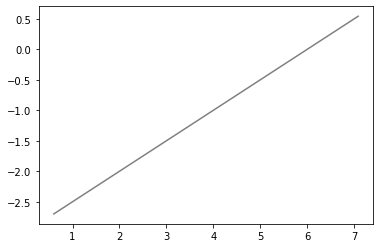

In [43]:
ptemp = np.linspace(0.6, p_fin, 100)

etemp = (ptemp - 6)/2
plt.plot(ptemp, etemp, 'grey')


In [ ]:
for p, p0, e0, mm in zip(p_out, p0_arr, e0_arr, mm_out):
    
    plt.plot(p, np.log10(mm), label='(%.2g, %.2g)'%(p0, e0))
    
plt.xlabel(r'$p_0$')
plt.ylabel(r'log$_{10}$(mismatch)')
plt.legend(ncol=3, loc='upper right')
plt.xlim(4,20)
plt.ylim(-4.25,-2.5)
plt.savefig('1d_1e5_chunks_over_t.pdf')

10.0 0.7
11.48 0.7
12.96 0.7
14.44 0.7
15.92 0.7
17.4 0.7
16.2 0.1
16.4 0.2
16.6 0.3
16.8 0.4
17.0 0.5
17.2 0.6
17.4 0.7


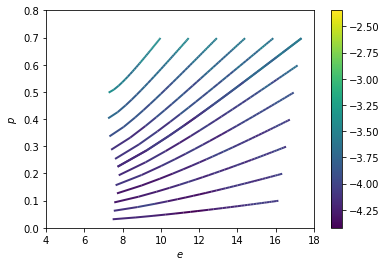

In [3]:
from scipy.interpolate import CubicSpline
from few.utils.overlap import get_mismatch
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plot_info = np.load('../plot_test_2.npy', allow_pickle=True)

p0_arr, e0_arr, mu_arr, mismatch, num_modes, fast_speed, slow_speed, last_time = plot_info.T

p0_arr = np.concatenate([p0_arr, [17.4]])
e0_arr = np.concatenate([e0_arr, [0.7]])
mu_arr = np.concatenate([mu_arr, [304.42722121]])

delta = 1e5

dt = 10.0

M = 1e6
p_out = []
e_out = []
mm_out = []
for p0, e0, mu in zip(p0_arr, e0_arr, mu_arr):
    t, p, e, pp, pr, flux = traj(M, mu, p0, e0, dt=100.0)
    splines = [CubicSpline(t, item) for item in [p, e, pp, pr, flux]]
      
    try:
        fast_all, slow_all = np.load("../wave_out_p_{}_e{}.npy".format(p0, e0))
        
    except ValueError:
        continue
        
    inds = np.arange(0, len(fast_all) + delta, delta).astype(int)
    p0_temp = []
    e0_temp = []
    mm_temp = []
    for st_ind, end_ind in zip(inds[:-1], inds[1:]):
        if end_ind > len(fast_all) or end_ind > len(slow_all):
            end_ind = np.min([len(fast_all), len(slow_all)])

        fast = fast_all[st_ind:end_ind]
        slow = slow_all[st_ind:end_ind]
        
        #pdb.set_trace()
        
        t_new = dt *(st_ind + (end_ind - st_ind)/2)
        
        mm_temp.append(get_mismatch(fast, slow))
        pn, en, ppn, prn, fluxn = [spl(t_new).item() for spl in splines]
        
        p0_temp.append(pn)
        e0_temp.append(en)
    p_out.append(p0_temp)
    e_out.append(e0_temp)
    mm_out.append(mm_temp)
    print(p0, e0)
            
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

norm = plt.Normalize(np.log10(np.min(np.concatenate(mm_out))), np.log10(np.max(np.concatenate(mm_out))))
for p, e, mm in zip(p_out, e_out, mm_out):
    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([p, e]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    # Create a continuous norm to map from data points to colors
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.log10(np.asarray(mm)))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(4.0, 18.0)
axs.set_ylim(0.0, 0.8)

#cb = plt.scatter(p_out, e_out, c=mm_out)
    
#cbar = plt.colorbar(cb)
plt.xlabel(r'$e$')
plt.ylabel(r'$p$')
plt.savefig("traj_mismatch_plot_1e5_chunks.pdf", dpi=20)

In [ ]:
p0_arr

In [ ]:
for p, p0, e0, mm in zip(p_out, p0_arr, e0_arr, mm_out):
    
    plt.plot(p, np.log10(mm), label='(%.2g, %.2g)'%(p0, e0))
    
plt.xlabel(r'$p_0$')
plt.ylabel(r'log$_{10}$(mismatch)')
plt.legend(ncol=3)
plt.savefig('1d_5e5_chunks.pdf')

In [ ]:
inds = np.arange(len(fast_all))[-1000000:]
plt.plot(fast_all[inds])
plt.plot(slow_all[inds])
mm = get_mismatch(fast_all[inds], slow_all[inds])
plt.title("mismatch: %.3e"%mm)
#plt.savefig('plunge_mismatch_10_07.pdf')

In [ ]:
np.asarray([mm])

In [ ]:
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([p, e]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(np.min(np.concatenate(np.log10(mm_out))), np.max(np.concatenate(np.log10(mm_out))))
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(np.asarray(np.log10(mm_out)))
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

axs[0].set_xlim(min(p), max(p))
axs[0].set_ylim(min(e), max(e))

In [9]:
M = 1e6

e0_arr = np.arange(0.1, 0.8, 0.1)
p0_arr = np.full_like(e0_arr, 16.0)

mu_arr = np.logspace(0, 3, 1000)

print(p0_arr, e0_arr)

t_end = np.zeros(len(p0_arr))
t_temp = np.zeros(len(mu_arr))
mu_best = np.zeros(len(p0_arr))
for i, (p0, e0) in enumerate(zip(p0_arr, e0_arr)):
    for j, mu in enumerate(mu_arr):
        t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)
        t_temp[j] = t[-1]
        if j % 100 == 0:
            print(j)
        
    ind = np.where(t_temp < 3.15576E+07)[0][0]
    t_end[i] = t_temp[ind]
    mu_best[i] = mu_arr[ind]
    print(p0, e0)


[16. 16. 16. 16. 16. 16. 16.] [0.1 0.2 0.3 0.4 0.5 0.6 0.7]
0
100
200
300
400
500
600
700
800
900
16.0 0.1
0
100
200
300
400
500
600
700
800
900
16.0 0.2
0
100
200
300
400
500
600
700
800
900
16.0 0.30000000000000004
0
100
200
300
400
500
600
700
800
900
16.0 0.4
0
100
200
300
400
500
600
700
800
900
16.0 0.5
0
100
200
300
400
500
600
700
800
900
16.0 0.6
0
100
200
300
400
500
600
700
800
900
16.0 0.7000000000000001


In [2]:
cpu_parts = ['ylm', 'traj', 'amp_cpu', 'mode_filter_cpu', 'cpu']
gpu_parts = ['ylm', 'traj', 'amp_gpu', 'mode_filter_gpu', 'gpu']

e0_arr = np.arange(0.1, 0.8, 0.1)
p0_arr = np.full_like(e0_arr, 16.0)
mu_arr = np.array([160.03103137, 161.14142773, 163.38538778, 166.81005372,
       173.87624002, 185.04070195, 205.26377527])

timing_list_cpu = []
ind_keep = -1
time_cumulative = 0.0
for i, part in enumerate(cpu_parts):
    _, _, timing, modes = np.load('../full_' + part + '_timing.npy', allow_pickle=True)
    time_i = timing[ind_keep]
    timing_list_cpu.append(time_i)

timing_list_cpu.append(timing_list_cpu[-1])
timing_list_cpu[-2] = timing_list_cpu[-2] - np.sum(timing_list_cpu[:-2])

    
timing_list_gpu = []
ind_keep = -1
for i, part in enumerate(gpu_parts):
    _, _, timing, modes = np.load('../full_' + part + '_timing.npy', allow_pickle=True)
    time_i = timing[ind_keep]
    timing_list_gpu.append(time_i)
    
timing_list_gpu.append(timing_list_gpu[-1])
timing_list_gpu[-2] = np.sum(timing_list_gpu[:-2])
    
timing_list_slow = np.insert(np.load('../slow_wave_timing.npy'), 3, 0.0)

timing_list_slow = np.append(timing_list_slow, timing_list_slow[-1])
timing_list_slow[-2] = timing_list_slow[-2] - np.sum(timing_list_slow[:-2])



    
df = pd.DataFrame(np.asarray([list(timing_list_gpu), timing_list_cpu, list(timing_list_slow)]).T, 
                  columns=['Fast (GPU)', 'Fast (CPU)', 'Slow'], 
                  index=['Angular\nHarmonics', 'Trajectory', 'Amplitudes', 'Mode\nSelection', 'Summation', 'Total'])

In [3]:
df

,Fast (GPU),Fast (CPU),Slow
Angular\nHarmonics,0.000079,0.000079,0.000081
Trajectory,0.008102,0.008102,89.156948
Amplitudes,0.008112,0.018768,3701.082373
Mode\nSelection,0.006277,0.173833,0.000000
Summation,0.022569,345.628672,2602.750528
Total,0.147725,345.829454,6392.989930


In [9]:
timing_list_slow

array([8.08624178e-05, 8.91569482e+01, 3.70108237e+03, 0.00000000e+00,
       2.60275053e+03, 6.39298993e+03])

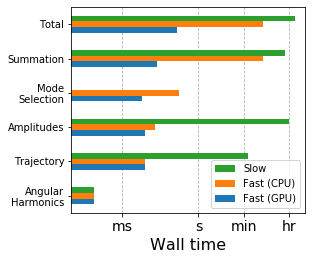

In [14]:
ax = df.plot.barh(stacked=False, logx=True, width=0.5, figsize=(5,4.2))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='lower right')  # reverse both handles and labels
plt.subplots_adjust(left=0.25, bottom=0.2)
ax.set_xlabel('Wall time', fontsize=16)
ax.set_xlim(1e-5,)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=10)
#ax.set_xticks(10**np.array([-3, 0, 3], dtype=float))
xticks = [1e-3, 1e0, 60.0, 3600.00]
ax.set_xticks(xticks)
ax.set_xticklabels(['ms', 's', 'min', 'hr'])

ax.grid(True, which='major', axis='x', ls='dashed')
ax.set_axisbelow(True)

#for xtick in xticks:
#    ax.axvline(xtick, ls='--')

plt.savefig('timing_plot_3.pdf', dpi=200)

In [70]:
ax

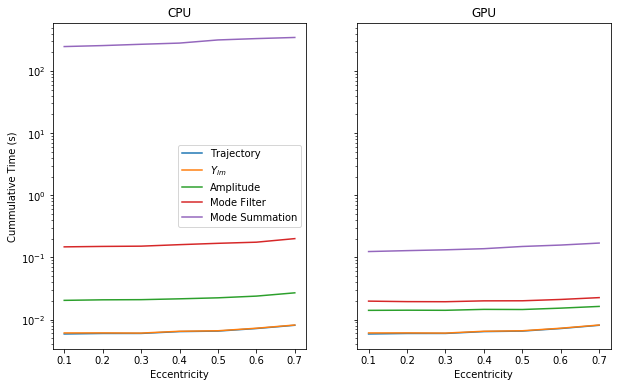

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_size_inches(10,6)
# plot traj timing
timing = hold['traj']['time']
ax1.semilogy(e0_arr, timing, label='Trajectory')
ax2.semilogy(e0_arr, timing)

# plot ylms calculation in addition
timing = timing + hold['ylm']['time']
ax1.semilogy(e0_arr, timing, label=r'$Y_{lm}$')
ax2.semilogy(e0_arr, timing)

# amplitude calculation
gpu_timing = timing + hold['amp_gpu']['time']
ax2.semilogy(e0_arr, gpu_timing)

timing = timing + hold['amp_cpu']['time']
ax1.semilogy(e0_arr, timing, label='Amplitude')


# mode filtering 
timing = timing + hold['mode_filter_cpu']['time']
ax1.semilogy(e0_arr, timing, label='Mode Filter')

gpu_timing = gpu_timing + hold['mode_filter_gpu']['time']
ax2.semilogy(e0_arr, gpu_timing)

store_gpu_timing = gpu_timing
store_timing = timing

# mode summation
timing = hold['cpu']['time']
ax1.semilogy(e0_arr, timing, label='Mode Summation')

gpu_timing = gpu_timing + hold['gpu']['time']
ax2.semilogy(e0_arr, gpu_timing)

ax1.set_title('CPU')
ax2.set_title('GPU')
ax1.set_ylabel('Cummulative Time (s)')

for ax in [ax1, ax2]:
    ax.set_xlabel('Eccentricity')

ax1.legend()
fig.savefig('cummulative_log_scale.pdf', dpi=200)

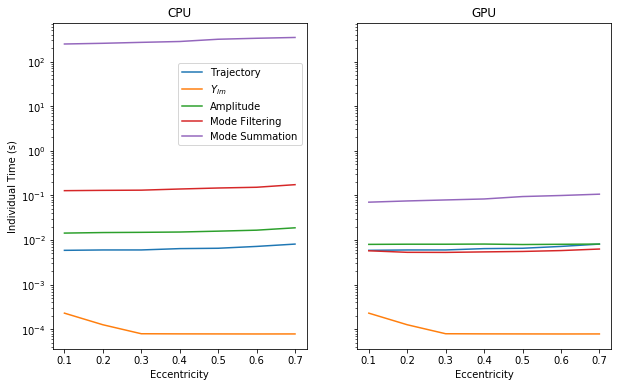

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_size_inches(10,6)
# plot traj timing
ax1.semilogy(e0_arr, hold['traj']['time'], label=r'Trajectory')
ax2.semilogy(e0_arr, hold['traj']['time'])

# plot ylms calculation in addition
ax1.semilogy(e0_arr, hold['ylm']['time'], label=r'$Y_{lm}$')
ax2.semilogy(e0_arr, hold['ylm']['time'])

# amplitude calculation
ax1.semilogy(e0_arr, hold['amp_cpu']['time'], label=r'Amplitude')
ax2.semilogy(e0_arr, hold['amp_gpu']['time'])

# mode filtering 
ax1.semilogy(e0_arr, hold['mode_filter_cpu']['time'], label=r'Mode Filtering')
ax2.semilogy(e0_arr, hold['mode_filter_gpu']['time'])

# mode summation
ax1.semilogy(e0_arr, hold['cpu']['time'] - store_timing, label='Mode Summation')
ax2.semilogy(e0_arr, hold['gpu']['time'] - store_gpu_timing)

ax1.set_title('CPU')
ax2.set_title('GPU')
ax1.set_ylabel('Individual Time (s)')

for ax in [ax1, ax2]:
    ax.set_xlabel('Eccentricity')
ax1.legend(loc='center right', bbox_to_anchor=[1., 0.75])
fig.savefig('individual_log_scale.pdf', dpi=200)

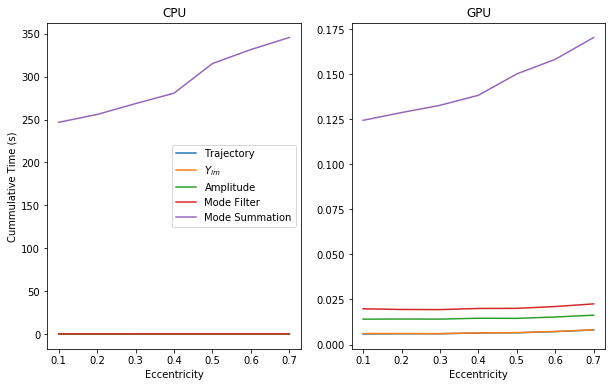

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,6)
# plot traj timing
timing = hold['traj']['time']
ax1.plot(e0_arr, timing, label='Trajectory')
ax2.plot(e0_arr, timing)

# plot ylms calculation in addition
timing = timing + hold['ylm']['time']
ax1.plot(e0_arr, timing, label=r'$Y_{lm}$')
ax2.plot(e0_arr, timing)

# amplitude calculation
gpu_timing = timing + hold['amp_gpu']['time']
ax2.plot(e0_arr, gpu_timing)

timing = timing + hold['amp_cpu']['time']
ax1.plot(e0_arr, timing, label='Amplitude')


# mode filtering 
timing = timing + hold['mode_filter_cpu']['time']
ax1.plot(e0_arr, timing, label='Mode Filter')

gpu_timing = gpu_timing + hold['mode_filter_gpu']['time']
ax2.plot(e0_arr, gpu_timing)

store_gpu_timing = gpu_timing
store_timing = timing

# mode summation
timing = hold['cpu']['time']
ax1.plot(e0_arr, timing, label='Mode Summation')

gpu_timing = gpu_timing + hold['gpu']['time']
ax2.plot(e0_arr, gpu_timing)

ax1.set_title('CPU')
ax2.set_title('GPU')
ax1.set_ylabel('Cummulative Time (s)')

for ax in [ax1, ax2]:
    ax.set_xlabel('Eccentricity')

ax1.legend()
fig.savefig('cummulative_linear_scale.pdf', dpi=200)

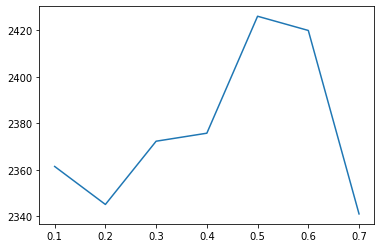

In [50]:
plt.plot(e0_arr, hold['cpu']['time']/hold['gpu']['time'])